In [1]:
# Librerie standard
import os
import random
import time
import re
import shutil
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice
from concurrent.futures import ProcessPoolExecutor
import warnings

# Librerie per il trattamento delle immagini
import cv2
import imageio.v3 as imageio
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Librerie per il machine learning e deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torchvision.ops.boxes import box_iou
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as TF
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Librerie per la gestione dei dati
import pandas as pd
import json
#import orjson
import ast

# Librerie per il progresso e il monitoraggio
from tqdm import tqdm

# Librerie per il deep learning avanzato
from torch.amp import GradScaler, autocast
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [2]:
COCO_JSON_NM = 'COCO_annotations_new.json' 
OUT_COCO_JSON_NM = 'mod_COCO_annotations_new.json'
OUT_IMAGE_FLDR_NM = 'images'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM

train_path = '/kaggle/working/train.json'
test_path = '/kaggle/working/test.json'
val_path = '/kaggle/working/val.json'

random.seed(RANDOM_SEED)

In [3]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

Cartella /kaggle/working pulita.


In [4]:
# Sopprime i warning specifici del modulo skimage
warnings.filterwarnings("ignore", 
    message="Applying `local_binary_pattern` to floating-point images may give unexpected results.*")

## Processing vecchio json

In [5]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    Seleziona casualmente il 50% delle immagini e aggiorna le annotazioni di conseguenza.
    """
    # Leggi il JSON dal file di input
    with open(input_path, 'r') as f:
        data = json.load(f)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []

    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")

    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11

    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})

    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)

    # Seleziona casualmente il 50% delle immagini
    all_images = data.get('images', [])
    selected_images = random.sample(all_images, len(all_images) // 2)
    selected_image_ids = {image['id'] for image in selected_images}

    # Filtra le annotazioni per includere solo quelle relative alle immagini selezionate
    selected_annotations = [
        annotation for annotation in data.get('annotations', [])
        if annotation['image_id'] in selected_image_ids
    ]

    # Lista di nuove annotazioni da aggiungere per immagini senza bbox
    new_annotations = []

    # Elenco di annotazioni da rimuovere
    annotations_to_remove = []

    for annotation in tqdm(selected_annotations, desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11

        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])

        x, y, width, height = annotation['bbox']
        xmin = x
        xmax = x + width
        ymin = y
        ymax = y + height

        # Verifica che xmin < xmax e ymin < ymax
        if xmin >= xmax or ymin >= ymax or width == 10 or height == 10:
            annotations_to_remove.append(annotation['id'])
        else:
            annotation['bbox'] = [xmin, xmax, ymin, ymax]

    # Rimuovi le annotazioni non valide
    selected_annotations = [
        ann for ann in selected_annotations if ann['id'] not in annotations_to_remove
    ]

    # Verifica se ci sono immagini senza annotazioni (usando il dizionario delle annotazioni)
    for image in tqdm(selected_images, desc="Processing Images"):
        if image['id'] not in image_annotations_dict:  # Se l'immagine non ha annotazioni
            # Aggiungi la categoria "background"
            new_annotation = {
                'id': len(selected_annotations) + len(new_annotations),
                'image_id': image['id'],
                'category_id': 0,  # Categoria background con ID 0
                'area': image['width'] * image['height'],
                'bbox': [0.0, image['width'], 0.0, image['height']],  # Background con bbox che copre tutta l'immagine
                'iscrowd': 0
            }
            new_annotations.append(new_annotation)

    # Aggiungi le nuove annotazioni al JSON selezionato
    selected_annotations.extend(new_annotations)

    # Aggiorna il JSON con le immagini e annotazioni selezionate
    processed_data = {
        'images': selected_images,
        'annotations': selected_annotations,
        'categories': categories
    }

    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(processed_data, f, indent=4)


In [15]:
def extract_categories_from_custom_coco_json(json_path):
    """
    Estrae i nomi delle categorie da un file JSON COCO personalizzato, ordinati per ID.

    Args:
        json_path (str): Path del file JSON COCO personalizzato.

    Returns:
        list: Lista di nomi delle categorie ordinate per ID.
    """
    # Leggi il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni le categorie dal JSON
    raw_categories = data.get('categories', [])
    
    # Crea una lista di categorie con id e nome
    categories = []
    for category in raw_categories:
        # Si assume che category sia un dizionario con "id" e "name"
        if isinstance(category, dict) and 'id' in category and 'name' in category:
            categories.append(category)
        else:
            print(f"Errore nel formato della categoria: {category}")
    
    # Ordina le categorie in base all'ID
    categories = sorted(categories, key=lambda cat: cat["id"])
    
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.insert(0, {"id": 0, "name": "background"})
    
    # Estrai solo i nomi delle categorie
    category_names = [cat["name"] for cat in categories]
    
    return category_names

In [7]:
def display_images_with_bboxes(json_file, specific_images, images_folder, mode = 2):
    """
    Visualizza le immagini specificate con tutti i bounding box sopra di esse.

    :param json_file: percorso del file JSON contenente le immagini, annotazioni e categorie
    :param specific_images: lista di nomi delle immagini da visualizzare
    :param images_folder: percorso della cartella che contiene le immagini
    """
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Estrai le immagini e le annotazioni
    images = data["images"]
    annotations = data["annotations"]

    # Crea un dizionario per mappare l'id delle immagini al nome del file
    image_dict = {image["id"]: image["file_name"] for image in images}

    # Filtra le annotazioni per le immagini specifiche
    specific_annotations = [ann for ann in annotations if image_dict[ann["image_id"]] in specific_images]

    # Creiamo un dizionario per raccogliere tutte le annotazioni per ciascuna immagine
    image_bboxes = {}
    for annotation in specific_annotations:
        image_name = image_dict[annotation["image_id"]]
        if image_name not in image_bboxes:
            image_bboxes[image_name] = []
        if mode == 1:
            bbox = ast.literal_eval(annotation["bbox"])
        else:
            bbox = annotation["bbox"]
        category_id = annotation["category_id"]
        image_bboxes[image_name].append((bbox, category_id))

    # Visualizza tutte le immagini con tutti i bounding box
    for image_name, bboxes in image_bboxes.items():
        # Carica l'immagine
        image_path = f'{images_folder}/{image_name}'  # Usa il percorso corretto per le immagini
        image = Image.open(image_path)

        # Crea la figura per la visualizzazione
        plt.figure(figsize=(8, 8))
        plt.imshow(image)

        # Aggiungi tutti i bounding box e il category_id
        if mode == 1:
            for bbox, category_id in bboxes:
                x, y, w, h = bbox
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')
        else:
            for bbox, category_id in bboxes:
                x, y, x2, y2 = bbox
                w = x2 - x
                h = y2 - y
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x, y - 5, f'Category: {category_id}', color='red', fontsize=10, backgroundcolor='white')

        # Imposta il titolo e disattiva gli assi
        plt.title(f"Image: {image_name}")
        plt.axis('off')
        plt.show()

In [8]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

Processing Images: 100%|██████████| 22945/22945 [00:00<00:00, 62619.43it/s]


In [16]:
# Estrai i nomi delle categorie
categories = extract_categories_from_custom_coco_json(new_coco_json_pth)
# Mostra i nomi delle categorie
print(categories)

# Creazione del label map e reverse label map
label_map = {idx: category for idx, category in enumerate(categories)}
rev_label_map = {category: idx for idx, category in enumerate(categories)}

['background', 'Passenger Vehicle', 'Truck', 'Railway Vehicle', 'Maritime Vessel', 'Engineering Vehicle', 'Building', 'Helipad', 'Storage Tank', 'Shipping Container', 'Pylon', 'Aircraft']


In [17]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

Processing Images: 100%|██████████| 22945/22945 [00:00<00:00, 462764.25it/s]


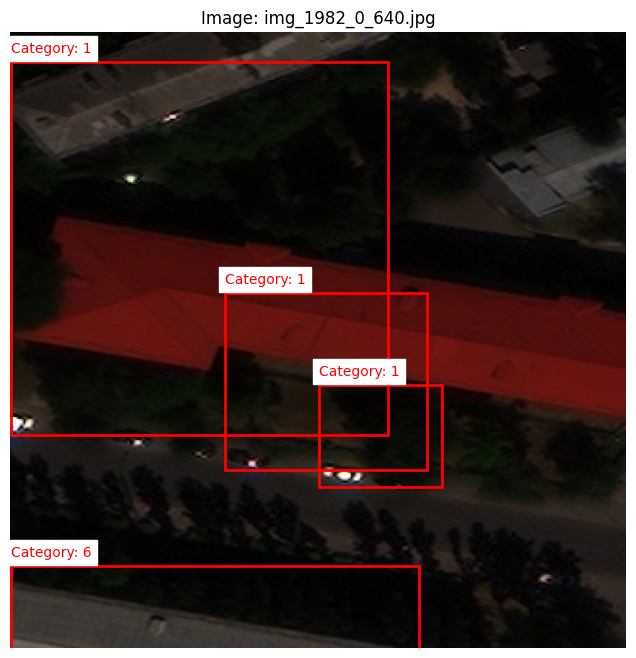

In [20]:
display_images_with_bboxes(new_coco_json_pth, 'img_1982_0_640.jpg', img_fldr)

## Preparazione nuovo json

In [ ]:
def count_bboxes_per_category(json_path):
    """
    Funzione che conta il numero di bounding box per ciascuna categoria in un file JSON formato COCO.
    
    :param json_path: Percorso al file JSON.
    :return: Dizionario con i nomi delle categorie come chiavi e il conteggio dei bounding box come valori.
    """
    # Leggi il JSON dal file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni mapping delle categorie (id -> nome)
    category_mapping = {cat['id']: cat['name'] for cat in data.get('categories', [])}
    
    # Conta i bounding box per ciascun category_id
    bbox_counts = defaultdict(int)
    for annotation in data.get('annotations', []):
        category_id = annotation['category_id']
        bbox_counts[category_id] += 1
    
    # Converti il conteggio usando i nomi delle categorie
    bbox_counts_named = {category_mapping[cat_id]: count for cat_id, count in bbox_counts.items()}

    return bbox_counts_named

In [ ]:
bbox_counts = count_bboxes_per_category(new_coco_json_pth)

# Stampa i risultati
for category, count in bbox_counts.items():
    print(f"Categoria: {category}, Numero di bbox: {count}")

In [ ]:
def filter_invalid_boxes(annotations):
    """Filtra le annotazioni con bounding box non validi, mantenendo la classe 'background'."""
    valid_annotations = []
    background_class_id = 0  # Supponiamo che '0' rappresenti la classe 'background'

    for annotation in annotations:
        bbox = annotation['bbox']
        category_id = annotation.get('category_id')

        if isinstance(bbox, str):
            try:
                bbox = json.loads(bbox)
            except json.JSONDecodeError:
                raise ValueError(f"Bounding box non valido: {bbox} (conversione da stringa fallita).")

        if len(bbox) == 4:
            x_min, y_min, width, height = bbox
            if width > 0 and height > 0 or category_id == background_class_id:
                annotation['bbox'] = [x_min, x_min + width, y_min, y_min + height]
                valid_annotations.append(annotation)

    return valid_annotations


def split(json_file, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Filtra le annotazioni con bounding box non validi
    valid_annotations = filter_invalid_boxes(data['annotations'])
    
    # Ottieni la lista delle immagini
    images = data['images']
    
    # Mescola casualmente gli ID delle immagini
    random.shuffle(images)
    
    # Calcola i limiti per train, validation e test
    total_images = len(images)
    total_annotations = len(valid_annotations)
    train_end = int(total_images * train_ratio)
    val_end = int(total_images * (train_ratio + val_ratio))
    
    # Suddividi le immagini nei rispettivi set
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]
    
    # Raggruppa gli ID delle immagini per i rispettivi set
    train_image_ids = {image['id'] for image in train_images}
    val_image_ids = {image['id'] for image in val_images}
    test_image_ids = {image['id'] for image in test_images}
    
    # Filtra le annotazioni per i rispettivi set di immagini
    train_annotations = [ann for ann in valid_annotations if ann['image_id'] in train_image_ids]
    val_annotations = [ann for ann in valid_annotations if ann['image_id'] in val_image_ids]
    test_annotations = [ann for ann in valid_annotations if ann['image_id'] in test_image_ids]
    
    # Crea i nuovi JSON per train, validation e test
    train_data = {'images': train_images, 'annotations': train_annotations, 'categories': data['categories']}
    val_data = {'images': val_images, 'annotations': val_annotations, 'categories': data['categories']}
    test_data = {'images': test_images, 'annotations': test_annotations, 'categories': data['categories']}
    
    # Salva i file JSON
    with open('train.json', 'w') as f:
        json.dump(train_data, f, indent=4)
    
    with open('val.json', 'w') as f:
        json.dump(val_data, f, indent=4)
    
    with open('test.json', 'w') as f:
        json.dump(test_data, f, indent=4)
    
    # Controlla la proporzione delle immagini e delle annotazioni
    check_split_proportions(total_images, total_annotations, 
                            len(train_images), len(val_images), len(test_images), 
                            len(train_annotations), len(val_annotations), len(test_annotations), 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, data['categories'])


def check_split_proportions(total_images, total_annotations, train_count, val_count, test_count, 
                            train_bbox_count, val_bbox_count, test_bbox_count, 
                            train_ratio, val_ratio, test_ratio, 
                            train_annotations, val_annotations, test_annotations, categories):
    # Percentuali per immagini
    train_image_percentage = (train_count / total_images) * 100
    val_image_percentage = (val_count / total_images) * 100
    test_image_percentage = (test_count / total_images) * 100
    
    # Percentuali per bbox
    train_bbox_percentage = (train_bbox_count / total_annotations) * 100
    val_bbox_percentage = (val_bbox_count / total_annotations) * 100
    test_bbox_percentage = (test_bbox_count / total_annotations) * 100
    
    print(f"Totale immagini: {total_images}")
    print(f"Totale annotazioni (bbox): {total_annotations}")
    print(f"Train: {train_count} immagini ({train_image_percentage:.2f}%) ({train_bbox_count} bbox) ({train_bbox_percentage:.2f}%)")
    print(f"Val: {val_count} immagini ({val_image_percentage:.2f}%) ({val_bbox_count} bbox) ({val_bbox_percentage:.2f}%)")
    print(f"Test: {test_count} immagini ({test_image_percentage:.2f}%) ({test_bbox_count} bbox) ({test_bbox_percentage:.2f}%)")
    
    # Calcola il numero di annotazioni per categoria nei vari set
    category_count_train = defaultdict(int)
    category_count_val = defaultdict(int)
    category_count_test = defaultdict(int)
    
    for annotation in train_annotations:
        category_count_train[annotation['category_id']] += 1
    for annotation in val_annotations:
        category_count_val[annotation['category_id']] += 1
    for annotation in test_annotations:
        category_count_test[annotation['category_id']] += 1
    
    # Stampa le proporzioni per categoria
    print("\nProporzioni per categoria:")
    for category in categories:
        try:
            category_id = int(category['id'])  # Converte 'id' in un intero
            category_name = category['name']
    
            # Conta il numero di annotazioni per categoria in ogni set
            train_cat_count = category_count_train.get(category_id, 0)
            val_cat_count = category_count_val.get(category_id, 0)
            test_cat_count = category_count_test.get(category_id, 0)
    
            # Calcola la percentuale di annotazioni per categoria
            total_cat_annotations = train_cat_count + val_cat_count + test_cat_count
            if total_cat_annotations > 0:
                train_cat_percentage = (train_cat_count / total_cat_annotations) * 100
                val_cat_percentage = (val_cat_count / total_cat_annotations) * 100
                test_cat_percentage = (test_cat_count / total_cat_annotations) * 100
            else:
                train_cat_percentage = val_cat_percentage = test_cat_percentage = 0.0
    
            print(f"{category_name}:")
            print(f"  Train: {train_cat_count} annotazioni ({train_cat_percentage:.2f}%)")
            print(f"  Val: {val_cat_count} annotazioni ({val_cat_percentage:.2f}%)")
            print(f"  Test: {test_cat_count} annotazioni ({test_cat_percentage:.2f}%)")
        except KeyError as e:
            print(f"Chiave mancante nella categoria: {e}")
        except ValueError as e:
            print(f"Errore nel parsing della categoria: {e}")


In [ ]:
# Chiamata della funzione
split(new_coco_json_pth)

## Dataloader

In [ ]:
import operator
class CustomDataset(Dataset):
    def __init__(self, json_file, img_dir, aug=False):
        """
        Inizializza il dataset personalizzato.
        Args:
        - json_file: Il file JSON preprocessato contenente immagini, annotazioni e categorie.
        - img_dir: La directory contenente le immagini.
        - aug: Booleano per attivare o meno l'augmentazione.
        """
        # Carica il file JSON preprocessato
        with open(json_file, 'r') as f:
            coco_data = json.load(f)

        # Estrai informazioni su immagini, annotazioni e categorie
        self.image_info = {image['id']: image['file_name'] for image in coco_data['images']}
        self.image_annotations = {}
        self.image_bboxes = {}

        # Estrai le classi (categorie) dal file JSON
        self.classes = {}
        for category in coco_data['categories']:
            category_id = category['id']  # ID numerico
            category_name = category['name']  # Nome della categoria
            self.classes[int(category_id)] = category_name


        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            bbox = annotation['bbox']

            # Associa annotazioni e bounding box alle immagini
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
                self.image_bboxes[image_id] = []
            
            self.image_annotations[image_id].append(annotation['category_id'])
            self.image_bboxes[image_id].append(bbox)

        # Configura il percorso delle immagini e seleziona solo immagini valide
        self.img_dir = img_dir
        self.image_paths = []
        self.image_ids = []
        for image_id, file_name in self.image_info.items():
            if image_id in self.image_annotations:
                img_path = os.path.join(img_dir, file_name)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.image_ids.append(image_id)

        # Definisci trasformazioni
        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.aug_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        self.aug = aug

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Recupera un'immagine e le sue annotazioni.
        """
        img_path = self.image_paths[index]
        img_id = self.image_ids[index]

        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')
        original_width, original_height = image.size

        # Applica le trasformazioni
        if self.aug:
            image_tensor = self.aug_transform(image)
        else:
            image_tensor = self.base_transform(image)

        # Recupera le annotazioni e i bounding box
        categories = self.image_annotations[img_id]
        bboxes = self.image_bboxes[img_id]

        # Calcola il ridimensionamento
        scale_x = 224 / original_width
        scale_y = 224 / original_height

        # Ridimensiona i bounding box
        scaled_bboxes = [
            torch.tensor([
                bbox[0] * scale_x,  # x_min
                bbox[1] * scale_y,  # y_min
                bbox[2] * scale_x,  # x_max
                bbox[3] * scale_y   # y_max
            ], dtype=torch.float32)
            for bbox in bboxes
        ]

        # Costruisci il target
        target = {
            "boxes": torch.stack(scaled_bboxes),
            "labels": torch.tensor(categories, dtype=torch.int64)
        }

        return image_tensor, target

In [ ]:
def collate_fn(batch):
    """
    Funzione di collation per il DataLoader, utile per il batching di immagini e annotazioni.
    La funzione restituirà un batch di immagini e un batch di target, formattato correttamente per Faster R-CNN.
    
    Args:
    - batch: lista di tuple (image, target)
    
    Returns:
    - images: batch di immagini
    - targets: lista di dizionari contenenti le annotazioni per ogni immagine
    """
    # Separa immagini e target
    images, targets = zip(*batch)

    # Converte la lista di immagini in un batch di immagini
    images = list(images)

    # Restituisci il batch
    return images, list(targets)

In [ ]:
# Creazione dei dataset
train_dataset = CustomDataset(train_path, img_dir=img_fldr, aug=True)
valid_dataset = CustomDataset(val_path, img_dir=img_fldr, aug=False)  
test_dataset = CustomDataset(test_path, img_dir=img_fldr, aug=False)  

# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

## Check Dataloader

In [ ]:
def validate_dataloader(dataloader):
    """
    Valida un DataLoader verificando che ogni immagine abbia un target associato
    e che nessun target sia `None` o vuoto.
    
    Args:
    - dataloader: Il DataLoader da verificare.
    
    Returns:
    - error_messages: Lista di messaggi di errore. Vuota se tutti i dati sono validi.
    """
    error_messages = []
    for batch_idx, (images, targets) in enumerate(dataloader):
        for idx, target in enumerate(targets):
            if target is None:
                error_messages.append(f"Batch {batch_idx}, Immagine {idx}: Target è None.")
            elif target["boxes"].numel() == 0 or target["labels"].numel() == 0:
                error_messages.append(
                    f"Batch {batch_idx}, Immagine {idx}: Target è vuoto o mancano 'boxes'/'labels'."
                )
    return error_messages

In [ ]:
# Validazione del DataLoader di training
train_errors = validate_dataloader(train_loader)

if train_errors:
    print("Errori nel DataLoader di training:")
    for error in train_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di training sono validi.")

In [ ]:
# Validazione del DataLoader di training
val_errors = validate_dataloader(val_loader)

if val_errors:
    print("Errori nel DataLoader di validation:")
    for error in val_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di validation sono validi.")

In [ ]:
# Validazione del DataLoader di training
test_errors = validate_dataloader(test_loader)

if test_errors:
    print("Errori nel DataLoader di test:")
    for error in test_errors:
        print(error)
else:
    print("Tutti i target nel DataLoader di test sono validi.")

In [ ]:
def count_images_and_targets(dataloader):
    """
    Conta il numero totale di immagini e target in un DataLoader.
    """
    num_images = 0
    num_targets = 0

    for images, targets in dataloader:
        # Conta le immagini nel batch
        num_images += len(images)
        
        # Conta i target per ogni immagine (numero di oggetti)
        for target in targets:
            num_targets += len(target["boxes"])  # Ogni immagine ha un numero di bounding boxes
    
    return num_images, num_targets

In [ ]:
num_images_train, num_targets_train = count_images_and_targets(train_loader)

print(f"Numero totale di immagini per il train: {num_images_train}")
print(f"Numero totale di target per il train: {num_targets_train}")

In [ ]:
num_images_val, num_targets_val = count_images_and_targets(val_loader)

print(f"Numero totale di immagini per il validation: {num_images_val}")
print(f"Numero totale di target per il validation: {num_targets_val}")

In [ ]:
num_images_test, num_targets_test = count_images_and_targets(test_loader)

print(f"Numero totale di immagini per il test: {num_images_test}")
print(f"Numero totale di target per il test: {num_targets_test}")

In [ ]:
print(f"Numero totale di immagini: {num_images_train + num_images_val +num_images_test}")
print(f"Numero totale di target: {num_targets_train + num_targets_val +num_targets_test}")

## Definizione delle funzioni di addestramento

def train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs=10, num_classes=12, accumulation_steps=4):
    """
    Addestra e valida il modello Faster R-CNN.
    """
    # Scaler per mixed precision training
    scaler = GradScaler()

    # Sposta il modello sul dispositivo
    model.to(device)

    train_losses = []
    val_losses = []
    train_confidence = []
    val_confidence = []

    for epoch in range(num_epochs):
        print(f"\nEpoca {epoch + 1}/{num_epochs}")

        # --------------------
        # Training
        # --------------------
        model.train()
        total_train_loss = 0.0
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for i, (images, targets) in enumerate(train_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast('cuda'):
                # Calcola le perdite
                loss_dict = model(images, targets)

                # Controlla che il risultato sia un dizionario
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Il modello ha restituito un oggetto non valido: {type(loss_dict)}")
                
                # Somma delle perdite
                losses = sum(loss for loss in loss_dict.values())

            # Backward pass con gradient scaling
            scaler.scale(losses).backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_train_loss += losses.item()
            train_loop.set_postfix(loss=losses.item())

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Perdita media di training: {avg_train_loss:.4f}")

        # Calcolo Precision e Recall per il training
        train_conf = compute_average_confidence(model, train_loader, device, num_classes)
        train_confidence.append(train_conf)
        #train_recall.append(train_rec)
        print(f"Average confidence di training: {train_conf:.4f}")

        # --------------------
        # Validazione
        # --------------------
        model.train()  # Necessario per calcolare la loss
        total_val_loss = 0.0
        val_loop = tqdm(val_loader, desc="Validazione", leave=False)

        for i, (images, targets) in enumerate(val_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calcolo delle perdite nella validazione
            with torch.no_grad(), autocast('cuda'):
                # Calcola la loss durante la validazione
                loss_dict = model(images, targets)
                
                # Controlla che il risultato sia un dizionario
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Il modello ha restituito un oggetto non valido: {type(loss_dict)}")
                
                # Somma delle perdite
                losses = sum(loss for loss in loss_dict.values())
                total_val_loss += losses.item()
                val_loop.set_postfix(loss=losses.item())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Perdita media di validazione: {avg_val_loss:.4f}")

        # Calcolo delle metriche Precision e Recall
        val_conf = compute_average_confidence(model, val_loader, device, num_classes)
        val_confidence.append(val_conf)
        #val_recall.append(val_rec)
        print(f"Average confidence di validazione: {val_conf:.4f}")

        # --------------------
        # Salvataggio del modello
        # --------------------
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"Modello salvato: model_epoch_{epoch + 1}.pth")

    return train_losses, val_losses, train_confidence, val_confidence

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs=10, num_classes=12, accumulation_steps=4):
    """
    Addestra e valida il modello Faster R-CNN.
    """
    # Scaler per mixed precision training
    scaler = GradScaler()

    # Sposta il modello sul dispositivo
    model.to(device)

    train_losses = []
    val_losses = []
    train_confidences = []
    val_confidences = []
    train_precisions = []
    train_recalls = []
    val_precisions = []
    val_recalls = []

    for epoch in range(num_epochs):
        print(f"\nEpoca {epoch + 1}/{num_epochs}")

        # --------------------
        # Training
        # --------------------
        model.train()
        total_train_loss = 0.0
        train_loop = tqdm(train_loader, desc="Training", leave=False)

        for i, (images, targets) in enumerate(train_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast('cuda'):
                # Calcola le perdite
                loss_dict = model(images, targets)

                # Controlla che il risultato sia un dizionario
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Il modello ha restituito un oggetto non valido: {type(loss_dict)}")
                
                # Somma delle perdite
                losses = sum(loss for loss in loss_dict.values())

            # Backward pass con gradient scaling
            scaler.scale(losses).backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_train_loss += losses.item()
            train_loop.set_postfix(loss=losses.item())

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Perdita media di training: {avg_train_loss:.4f}")

        # Calcolo metriche per il training
        train_precision, train_recall, train_conf = evaluate_metrics(model, train_loader, device, num_classes)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_confidences.append(train_conf)
        print(f"Precision di training: {train_precision:.4f}, Recall di training: {train_recall:.4f}, Confidenza media di training: {train_conf:.4f}")

        # --------------------
        # Validazione
        # --------------------
        model.train()  # Necessario per calcolare la loss
        total_val_loss = 0.0
        val_loop = tqdm(val_loader, desc="Validazione", leave=False)

        for i, (images, targets) in enumerate(val_loop):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calcolo delle perdite nella validazione
            with torch.no_grad(), autocast('cuda'):
                loss_dict = model(images, targets)
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Il modello ha restituito un oggetto non valido: {type(loss_dict)}")
                losses = sum(loss for loss in loss_dict.values())
                total_val_loss += losses.item()
                val_loop.set_postfix(loss=losses.item())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Perdita media di validazione: {avg_val_loss:.4f}")

        # Calcolo metriche per la validazione
        val_precision, val_recall, val_conf = evaluate_metrics(model, val_loader, device, num_classes)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_confidences.append(val_conf)
        print(f"Precision di validazione: {val_precision:.4f}, Recall di validazione: {val_recall:.4f}, Confidenza media di validazione: {val_conf:.4f}")

        # --------------------
        # Salvataggio del modello
        # --------------------
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"Modello salvato: model_epoch_{epoch + 1}.pth")

    return train_losses, val_losses, train_precisions, train_recalls, train_confidences, val_precisions, val_recalls, val_confidences


def evaluate_precision_recall(model, data_loader, device, num_classes, iou_threshold=0.5, score_threshold=0.5):
    """
    Calcola Precision e Recall basati su IoU per Faster R-CNN.
    """
    model.eval()
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Predizioni
            outputs = model(images)

            for target, output in zip(targets, outputs):
                target_boxes = target['boxes'].cpu()
                target_labels = target['labels'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()

                # Filtra predizioni con punteggio basso
                high_score_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[high_score_indices]
                pred_labels = pred_labels[high_score_indices]

                # Confronta predizioni e target
                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    ious = box_iou(pred_boxes, target_boxes)  # IoU
                    for pred_idx, pred_label in enumerate(pred_labels):
                        iou_values = ious[pred_idx]
                        max_iou_idx = torch.argmax(iou_values)
                        max_iou = iou_values[max_iou_idx]

                        if max_iou >= iou_threshold and pred_label == target_labels[max_iou_idx]:
                            true_positives[pred_label] += 1
                            ious[:, max_iou_idx] = 0  # Disabilita target già usati
                        else:
                            false_positives[pred_label] += 1

                # False negatives
                for target_label in target_labels:
                    if target_label not in pred_labels:
                        false_negatives[target_label] += 1

    # Precision e Recall
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives) + 1e-6)
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives) + 1e-6)

    return precision, recall

def compute_average_confidence(model, data_loader, device, num_classes, iou_threshold=0.5, score_threshold=0.5):
    """
    Calcola la confidenza media per le predizioni corrette basate su IoU e score.
    """
    model.eval()  # Set the model to evaluation mode

    total_confidence = 0.0
    num_valid_predictions = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating Confidences", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            outputs = model(images)

            for target, output in zip(targets, outputs):
                target_boxes = target['boxes'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()

                # Filter out predictions with low scores
                high_score_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[high_score_indices]
                pred_scores = pred_scores[high_score_indices]

                # Only compute confidence if there are valid predictions
                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    # Compute IoU
                    ious = box_iou(pred_boxes, target_boxes)

                    for pred_idx in range(len(pred_boxes)):
                        iou_values = ious[pred_idx]
                        max_iou_idx = torch.argmax(iou_values)
                        max_iou = iou_values[max_iou_idx]

                        # If IoU is above threshold and label matches, count as a correct prediction
                        if max_iou >= iou_threshold:
                            total_confidence += pred_scores[pred_idx].item()
                            num_valid_predictions += 1

    # Return the average confidence (mean of correct predictions' scores)
    average_confidence = total_confidence / num_valid_predictions if num_valid_predictions > 0 else 0.0
    print(num_valid_predictions)
    return average_confidence


In [ ]:
def evaluate_metrics(model, data_loader, device, num_classes, iou_threshold=0.5, score_threshold=0.5):
    """
    Calcola Precision, Recall e la confidenza media basati su IoU per Faster R-CNN.
    """
    model.eval()
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    total_confidence = 0.0
    num_valid_predictions = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Predizioni
            outputs = model(images)

            for target, output in zip(targets, outputs):
                target_boxes = target['boxes'].cpu()
                target_labels = target['labels'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()

                # Filtra predizioni con punteggio basso
                high_score_indices = pred_scores > score_threshold
                pred_boxes = pred_boxes[high_score_indices]
                pred_labels = pred_labels[high_score_indices]
                pred_scores = pred_scores[high_score_indices]

                if len(pred_boxes) > 0 and len(target_boxes) > 0:
                    ious = box_iou(pred_boxes, target_boxes)  # IoU
                    for pred_idx, pred_label in enumerate(pred_labels):
                        iou_values = ious[pred_idx]
                        max_iou_idx = torch.argmax(iou_values)
                        max_iou = iou_values[max_iou_idx]

                        if max_iou >= iou_threshold and pred_label == target_labels[max_iou_idx]:
                            true_positives[pred_label] += 1
                            total_confidence += pred_scores[pred_idx].item()
                            num_valid_predictions += 1
                            ious[:, max_iou_idx] = 0  # Disabilita target già usati
                        else:
                            false_positives[pred_label] += 1

                # False negatives
                for target_label in target_labels:
                    if target_label not in pred_labels:
                        false_negatives[target_label] += 1

    # Precision e Recall globali
    precision = sum(true_positives) / (sum(true_positives) + sum(false_positives) + 1e-6)
    recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives) + 1e-6)

    # Confidenza media
    average_confidence = total_confidence / num_valid_predictions if num_valid_predictions > 0 else 0.0

    return precision, recall, average_confidence


def plot_metrics(train_losses, val_losses, train_precision, val_precision, train_recall, val_recall, num_epochs):
    """
    Funzione per plottare le metriche di training e validazione (Loss e mAP).
    """
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))

    # Plot della Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss per Epoca')

    # Plot della precision
    plt.subplot(3, 1, 2)
    plt.plot(epochs_range, train_precision, label='Training precision', color='green')
    plt.plot(epochs_range, val_precision, label='Validation precision', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision per Epoca')

    # Plot della recall
    plt.subplot(3, 1, 3)
    plt.plot(epochs_range, train_recall, label='Training recall', color='blue')
    plt.plot(epochs_range, val_recall, label='Validation recall', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall per Epoca')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics(train_losses, val_losses, train_avg_confidence, val_avg_confidence, num_epochs): 
    """ Funzione per plottare le metriche di training e validazione (Loss e mAP). """ 
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))
    
    # Plot della Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss per Epoca')
    
    # Plot della precision
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_avg_confidence, label='Training precision', color='green')
    plt.plot(epochs_range, val_avg_confidence, label='Validation precision', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Average Confidence per Epoca')
    
    plt.tight_layout()
    plt.show()

## Training

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

# Carica il modello Faster R-CNN con ResNet50 e FPN
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

In [ ]:
num_classes = 12

# Modifica il numero di classi in output
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Congela i layer della backbone (ResNet50)
for param in model.backbone.parameters():
    param.requires_grad = True

# Imposta il dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configurazione training
num_epochs = 2
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Sposta il modello su GPU o CPU
model.to(device)

train_losses, val_losses, train_precision, val_precision, train_recall, val_recall = train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs)

In [ ]:
train_losses, val_losses, train_avg_confidence, val_avg_confidence = train_and_validate(model, train_loader, val_loader, optimizer, device, num_epochs)

In [ ]:
plot_metrics(train_losses, val_losses, train_avg_confidence, val_avg_confidence, num_epochs)

## Testing

In [ ]:
def extract_categories_from_coco_json(json_path):
    """
    Estrae i nomi delle categorie da un file JSON in formato COCO.

    Args:
        json_path (str): Path del file JSON COCO.

    Returns:
        list: Lista di nomi delle categorie ordinate.
    """
    # Leggi il file JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Ottieni i nomi delle categorie
    categories = [cat["name"] for cat in data.get('categories', [])]
    
    # Ordina i nomi delle categorie
    categories = sorted(categories)
    
    # Aggiungi una categoria "background" come primo elemento se non esiste
    if "background" not in categories:
        categories.insert(0, "background")
    
    return categories

# Path al file JSON COCO
json_path = "/kaggle/working/mod_COCO_annotations_new.json"

# Estrai i nomi delle categorie
categories = extract_categories_from_coco_json(json_path)

# Mostra i nomi delle categorie
print(categories)

In [ ]:
def test_model(model, test_loader, device, class_names, num_classes=12, num_visualizations=5):
    """
    Funzione per il testing del modello Faster R-CNN.
    """
    model.to(device)
    model.eval()
    predictions = []
    all_preds = []  # Per calcolo mAP
    all_targets = []  # Per calcolo mAP

    print("\nInizio testing...")
    test_loop = tqdm(test_loader, desc="Testing", leave=False)
    visualized = 0  # Contatore per visualizzazioni

    with torch.no_grad():
        for images, targets in test_loop:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Targets su dispositivo

            # Predizioni dal modello
            preds = model(images)

            for pred, target in zip(preds, targets):
                predictions.append({
                    'boxes': pred['boxes'].cpu().numpy(),
                    'labels': pred['labels'].cpu().numpy(),
                    'scores': pred['scores'].cpu().numpy()
                })

                # Raccogli predizioni e target per calcolo mAP
                all_preds.append(pred)
                all_targets.append(target)

                # Visualizza immagini con bounding box
                if visualized < num_visualizations:
                    visualize_predictions(
                        images[0].cpu().numpy().transpose(1, 2, 0),  # Converti (C, H, W) -> (H, W, C)
                        pred['boxes'].cpu().numpy(),
                        pred['labels'].cpu().numpy(),
                        pred['scores'].cpu().numpy(),
                        class_names
                    )
                    visualized += 1

            # Aggiorna barra di avanzamento
            test_loop.set_postfix(processed=len(predictions))

    # Calcola e visualizza statistiche globali
    total_preds = sum(len(pred['labels']) for pred in all_preds)
    total_targets = sum(len(target['labels']) for target in all_targets)
    average_preds_per_image = total_preds / len(all_preds) if all_preds else 0
    average_targets_per_image = total_targets / len(all_targets) if all_targets else 0

    print("\nStatistiche globali del test set:")
    print(f"Numero totale di immagini processate: {len(all_preds)}")
    print(f"Numero totale di oggetti predetti: {total_preds}")
    print(f"Numero totale di oggetti target: {total_targets}")
    print(f"Numero medio di predizioni per immagine: {average_preds_per_image:.2f}")
    print(f"Numero medio di oggetti target per immagine: {average_targets_per_image:.2f}")

    # Visualizza la confusion matrix
    plot_confusion_matrix(all_preds, all_targets, class_names)

    print("Testing completato.")
    return predictions


def test_model(model, test_loader, device, class_names=categories, num_classes=12, score_threshold=0.5, iou_threshold=0.5):
    """
    Testa il modello su un set di dati di test calcolando Precision, Recall e altre metriche, inclusa la confidenza media.
    """
    model.to(device)
    model.eval()  # Metti il modello in modalità di valutazione

    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    total_test_loss = 0.0
    loss_count = 0
    total_test_confidence = 0.0  # Per accumulare la confidenza media

    test_loop = tqdm(test_loader, desc="Testing", leave=False)

    with torch.no_grad():
        for images, targets in test_loop:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Calcolo delle predizioni
            outputs = model(images)

            # Calcolo della loss per monitoraggio
            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                total_test_loss += losses.item()
                loss_count += 1

            # Aggiorna le metriche per precision, recall
            for target, output in zip(targets, outputs):
                true_positives, false_positives, false_negatives = update_metrics(
                    target, output, true_positives, false_positives, false_negatives,
                    iou_threshold=iou_threshold, score_threshold=score_threshold
                )

                # Calcola la confidenza media per le predizioni corrette
                total_test_confidence += compute_average_confidence(target, output, iou_threshold)

    # Calcola la perdita media
    avg_test_loss = total_test_loss / loss_count if loss_count > 0 else 0.0
    avg_test_confidence = total_test_confidence / len(test_loader)  # Media della confidenza su tutti i batch

    print(f"Perdita media di test: {avg_test_loss:.4f}")
    print(f"Confidenza media di test: {avg_test_confidence:.4f}")
    print(f"Numero medio di predizioni per immagine: {average_preds_per_image:.2f}")
    print(f"Numero medio di oggetti target per immagine: {average_targets_per_image:.2f}")

    # Visualizza la confusion matrix
    plot_confusion_matrix(all_preds, all_targets, class_names)

    return {
        "average_loss": avg_test_loss,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "average_confidence": avg_test_confidence
    }


In [ ]:
def visualize_predictions(image, boxes, labels, scores, class_names, threshold=0.5):
    """
    Visualizza le predizioni (bounding boxes e etichette) su una singola immagine.
    """
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Filtra predizioni con punteggio sopra la soglia
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            # Rettangolo per la bounding box
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                      linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Etichetta con classe e punteggio
            ax.text(box[0], box[1] - 10, f'{class_names[label]}: {score:.2f}', color='r',
                    fontsize=12, fontweight='bold', backgroundcolor='white')

    plt.show()

def plot_confusion_matrix(all_preds, all_targets, class_names, score_threshold=0.5):
    """
    Calcola e visualizza la confusion matrix.
    """
    pred_labels = []
    true_labels = []

    for pred, target in zip(all_preds, all_targets):
        # Filtra le predizioni in base al punteggio
        valid_indices = pred['scores'] >= score_threshold
        filtered_pred_labels = pred['labels'][valid_indices].cpu().numpy()

        # Aggiungi tutte le etichette previste e reali
        pred_labels.extend(filtered_pred_labels)
        true_labels.extend(target['labels'].cpu().numpy())

    # Assicurati che il numero di previsioni e target sia coerente
    if len(pred_labels) != len(true_labels):
        min_len = min(len(pred_labels), len(true_labels))
        pred_labels = pred_labels[:min_len]
        true_labels = true_labels[:min_len]

    # Calcola la matrice di confusione
    cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))
    #cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per riga

    # Visualizza la matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


    #sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    

In [ ]:
predictions = test_model(model, test_loader, device, class_names=categories, num_classes=num_classes)


In [ ]:
def test_model(net, test_loader, criterion, device, path_min_loss, json_path, original_img_path, reference_json_path):
    """
    Funzione per testare il modello e visualizzare i risultati su immagini originali.

    :param net: Modello da testare.
    :param test_loader: DataLoader per il test set.
    :param criterion: Funzione di loss.
    :param device: Dispositivo (CPU o GPU).
    :param path_min_loss: Percorso del modello salvato.
    :param json_path: Percorso al file JSON contenente i dettagli delle immagini del test set.
    :param original_img_path: Percorso al folder delle immagini originali.
    :param reference_json_path: Percorso al file JSON contenente le informazioni delle immagini originali.
    """
    # Carica il miglior modello salvato (con il parametro weights_only=True per evitare il warning)
    net.load_state_dict(torch.load(path_min_loss, map_location=device))
    net.eval()

    test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_labels = []
    all_predictions = []

    # Carica i file JSON
    with open(json_path, 'r') as f:
        test_data = json.load(f)

    with open(reference_json_path, 'r') as f:
        reference_data = json.load(f)

    # Crea un dizionario per una ricerca rapida delle immagini originali
    id_to_filename = {img['id']: img['file_name'] for img in reference_data['images']}

    # Crea un dizionario per raggruppare i bounding box per image_id
    image_id_to_bboxes = {}
    for image_info in test_data:
        image_id = image_info['image_id']
        region_bbox = image_info['region_bbox']
        if image_id not in image_id_to_bboxes:
            image_id_to_bboxes[image_id] = []
        image_id_to_bboxes[image_id].append(region_bbox)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss
            loss = criterion(outputs, labels)

            # Statistiche
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

            # Salva tutte le etichette e predizioni
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Mostra alcuni esempi
            if idx < 5:  # Mostra i primi 5 batch
                for i in range(min(len(images), 3)):  # Mostra fino a 3 immagini per batch
                    image_info = test_data[idx * len(images) + i]  # Recupera info immagine dal JSON
                    image_id = image_info['image_id']

                    # Trova il file_name usando l'image_id
                    file_name = id_to_filename.get(image_id)
                    if not file_name:
                        print(f"Immagine con ID {image_id} non trovata nel reference JSON.")
                        continue

                    # Percorso dell'immagine originale
                    img_path = os.path.join(original_img_path, file_name)

                    # Carica l'immagine originale
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Immagine non trovata: {img_path}")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Disegna i bounding box per le etichette reali (blu)
                    bboxes_real = image_id_to_bboxes.get(image_id, [])
                    for bbox in bboxes_real:
                        xmin, ymin, xmax, ymax = bbox
                        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  # Blu per reale

                    # Mostra l'immagine con i bounding box (senza le etichette scritte nell'immagine)
                    plt.figure(figsize=(6, 6))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.show()

                    # Ora stampa le etichette predette e reali sotto l'immagine
                    print(f"Predizioni vs Realtà per l'immagine {file_name}:")
                    for j, bbox in enumerate(bboxes_real):
                        pred_label = predicted[i].item()
                        # Stampa i valori predetti e reali
                        print(f"  Bounding Box {j + 1}: Predetto: {pred_label}, Reale: {labels[i].item()}")

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100. * correct_test / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per riga

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()